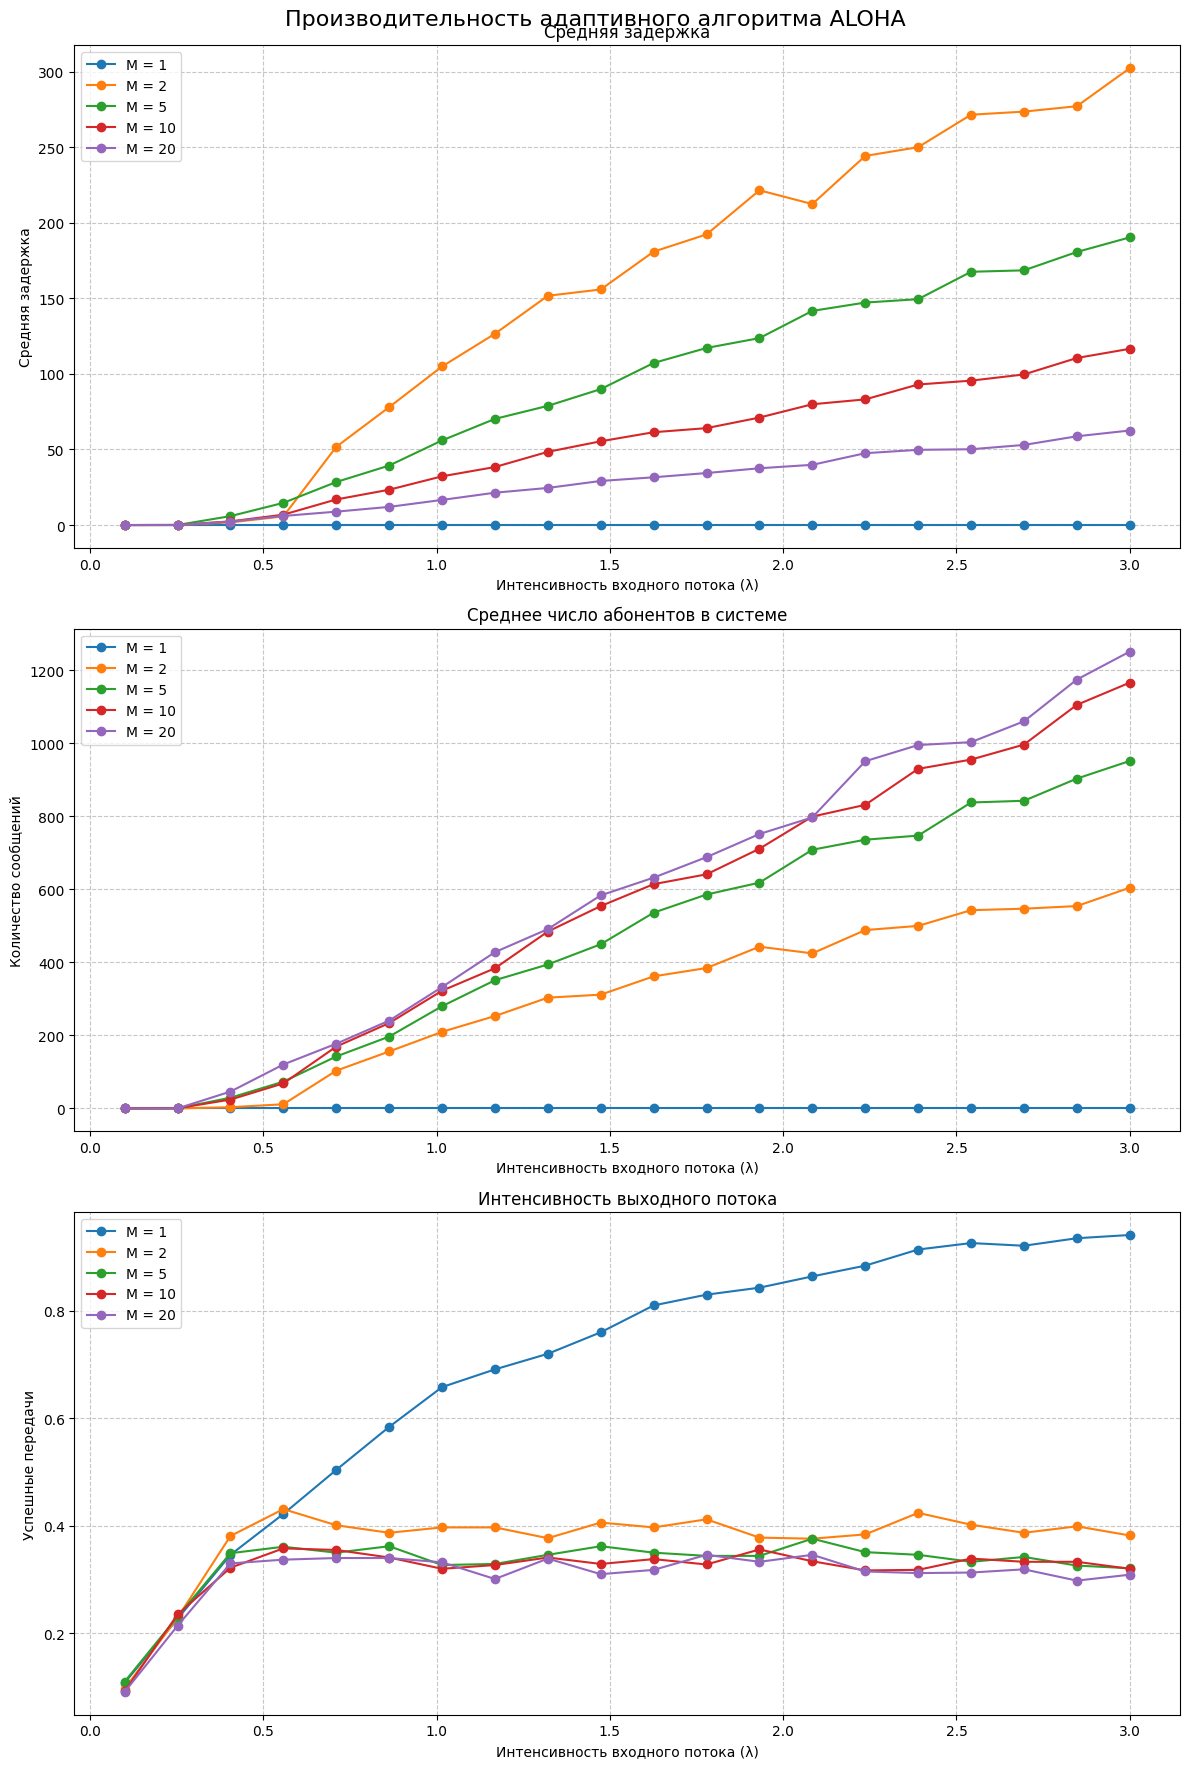


Average Delay Results:
M: 1, λ: 0.10, Value: 0.0000
M: 1, λ: 0.25, Value: 0.0000
M: 1, λ: 0.41, Value: 0.0000
M: 1, λ: 0.56, Value: 0.0000
M: 1, λ: 0.71, Value: 0.0000
M: 1, λ: 0.86, Value: 0.0000
M: 1, λ: 1.02, Value: 0.0000
M: 1, λ: 1.17, Value: 0.0000
M: 1, λ: 1.32, Value: 0.0000
M: 1, λ: 1.47, Value: 0.0000
M: 1, λ: 1.63, Value: 0.0000
M: 1, λ: 1.78, Value: 0.0000
M: 1, λ: 1.93, Value: 0.0000
M: 1, λ: 2.08, Value: 0.0000
M: 1, λ: 2.24, Value: 0.0000
M: 1, λ: 2.39, Value: 0.0000
M: 1, λ: 2.54, Value: 0.0000
M: 1, λ: 2.69, Value: 0.0000
M: 1, λ: 2.85, Value: 0.0000
M: 1, λ: 3.00, Value: 0.0000
M: 2, λ: 0.10, Value: 0.0020
M: 2, λ: 0.25, Value: 0.0385
M: 2, λ: 0.41, Value: 1.7420
M: 2, λ: 0.56, Value: 5.7355
M: 2, λ: 0.71, Value: 51.7405
M: 2, λ: 0.86, Value: 78.0075
M: 2, λ: 1.02, Value: 104.9055
M: 2, λ: 1.17, Value: 126.5460
M: 2, λ: 1.32, Value: 151.6765
M: 2, λ: 1.47, Value: 155.8335
M: 2, λ: 1.63, Value: 180.8605
M: 2, λ: 1.78, Value: 192.2580
M: 2, λ: 1.93, Value: 221.4420
M: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

class AdaptiveALOHASimulation:
    def __init__(self, 
                 num_subscribers: int, 
                 input_intensity: float, 
                 max_queue_size: int = float('inf'), 
                 simulation_time: int = 1000):
        """
        Initialize Adaptive ALOHA Simulation
        
        Args:
            num_subscribers (int): Total number of subscribers
            input_intensity (float): Message generation intensity
            max_queue_size (int): Maximum queue size per subscriber
            simulation_time (int): Total simulation duration
        """
        self.M = num_subscribers
        self.λ = input_intensity
        self.max_queue_size = max_queue_size
        self.simulation_time = simulation_time
        
        # Simulation state variables
        self.subscribers_queues = [[] for _ in range(self.M)]
        self.transmission_probabilities = [1/self.M] * self.M
        self.transmission_windows = [1] * self.M
        
        # Performance metrics
        self.delays = []
        self.system_load = []
        self.throughput = []
    
    def generate_messages(self):
        """
        Generate Poisson distributed messages for each subscriber
        """
        for i in range(self.M):
            # Each subscriber generates messages with λ/M intensity
            if np.random.poisson(self.λ/self.M) > 0:
                if len(self.subscribers_queues[i]) < self.max_queue_size:
                    self.subscribers_queues[i].append(1)
    
    def select_transmission_candidates(self) -> List[int]:
        """
        Select subscribers who will attempt transmission
        
        Returns:
            List of subscriber indices attempting transmission
        """
        candidates = []
        for i in range(self.M):
            if self.subscribers_queues[i] and np.random.random() < self.transmission_probabilities[i]:
                candidates.append(i)
        return candidates
    
    def update_transmission_probabilities(self, channel_state: str):
        """
        Update transmission probabilities based on channel state
        
        Args:
            channel_state (str): 'conflict', 'success', or 'empty'
        """
        for i in range(self.M):
            if channel_state == 'conflict':
                # Decrease probability, but not below 1/M
                self.transmission_probabilities[i] = max(1/self.M, self.transmission_probabilities[i]/2)
            
            elif channel_state == 'empty':
                # Increase probability, but not above 1
                self.transmission_probabilities[i] = min(1, 2 * self.transmission_probabilities[i])
    
    def simulate(self) -> Dict[str, List[float]]:
        """
        Run full simulation
        
        Returns:
            Dictionary of performance metrics
        """
        for t in range(self.simulation_time):
            # Generate messages
            self.generate_messages()
            
            # Select transmission candidates
            candidates = self.select_transmission_candidates()
            
            # Determine channel state
            if len(candidates) > 1:
                # Conflict
                channel_state = 'conflict'
                self.update_transmission_probabilities(channel_state)
            elif len(candidates) == 1:
                # Successful transmission
                channel_state = 'success'
                # Remove message from subscriber's queue
                self.subscribers_queues[candidates[0]].pop(0)
                self.update_transmission_probabilities(channel_state)
            else:
                # Empty channel
                channel_state = 'empty'
                self.update_transmission_probabilities(channel_state)
            
            # Track metrics
            self.delays.append(self._calculate_average_delay())
            self.system_load.append(sum(len(q) for q in self.subscribers_queues))
            self.throughput.append(1 if channel_state == 'success' else 0)
        
        return {
            'average_delay': self.delays,
            'system_load': self.system_load,
            'throughput': self.throughput
        }
    
    def _calculate_average_delay(self) -> float:
        """
        Calculate average delay across all queues
        """
        total_messages = sum(len(q) for q in self.subscribers_queues)
        return total_messages / self.M if total_messages > 0 else 0
    
    def plot_metrics(self, metrics: Dict[str, List[float]]):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
        
        # Average Delay Plot
        ax1.plot(metrics['average_delay'])
        ax1.set_title('Average Delay vs Time')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Average Delay')
        
        # System Load Plot
        ax2.plot(metrics['system_load'])
        ax2.set_title('System Load vs Time')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Number of Messages')
        
        # Throughput Plot
        ax3.plot(metrics['throughput'])
        ax3.set_title('Throughput vs Time')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Successful Transmissions')
        
        plt.tight_layout()
        plt.show()

def run_multiple_simulations(num_subscribers_range: List[int], 
                              input_intensities: List[float]) -> Dict[str, List[Tuple]]:
    results = {
        'average_delay': [],
        'system_load': [],
        'throughput': []
    }
    
    for M in num_subscribers_range:
        for λ in input_intensities:
            sim = AdaptiveALOHASimulation(M, λ)
            metrics = sim.simulate()
            
            # Store final average of metrics
            results['average_delay'].append((M, λ, np.mean(metrics['average_delay'])))
            results['system_load'].append((M, λ, np.mean(metrics['system_load'])))
            results['throughput'].append((M, λ, np.mean(metrics['throughput'])))
    
    return results

def plot_performance_metrics(results: Dict[str, List[Tuple]]):
    """
    Generate comprehensive performance metric plots
    
    Args:
        results (dict): Performance metrics from multiple simulations
    """
    # Set up the figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    plt.subplots_adjust(hspace=0.4)
    
    # Define metrics and their plot configurations
    metrics_config = [
        ('average_delay', 'Средняя задержка', 'Интенсивность входного потока (λ)', 'Средняя задержка'),
        ('system_load', 'Среднее число абонентов в системе', 'Интенсивность входного потока (λ)', 'Количество сообщений'),
        ('throughput', 'Интенсивность выходного потока', 'Интенсивность входного потока (λ)', 'Успешные передачи')
    ]
    
    # Plot each metric
    for i, (metric_key, title, xlabel, ylabel) in enumerate(metrics_config):
        # Group results by number of subscribers
        subscribers_groups = {}
        for M, λ, value in results[metric_key]:
            if M not in subscribers_groups:
                subscribers_groups[M] = ([], [])
            subscribers_groups[M][0].append(λ)
            subscribers_groups[M][1].append(value)
        
        # Plot lines for each subscriber count
        for M, (λ_values, values) in subscribers_groups.items():
            sorted_indices = np.argsort(λ_values)
            sorted_λ = np.array(λ_values)[sorted_indices]
            sorted_values = np.array(values)[sorted_indices]
            
            axs[i].plot(sorted_λ, sorted_values, marker='o', label=f'M = {M}')
        
        axs[i].set_title(title)
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].legend()
    
    plt.suptitle('Производительность адаптивного алгоритма ALOHA', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage and demonstration
def main():
    # Simulation parameters
    subscribers_range = [1, 2, 5, 10, 20]
    input_intensities = np.linspace(0.1, 3.0, 20)
    
    # Run simulations
    results = run_multiple_simulations(subscribers_range, input_intensities)
    
    # Generate performance plots
    plot_performance_metrics(results)
    
    # Optional: Print detailed results
    for metric_name, metric_results in results.items():
        print(f"\n{metric_name.replace('_', ' ').title()} Results:")
        for M, λ, value in metric_results:
            print(f"M: {M}, λ: {λ:.2f}, Value: {value:.4f}")

if __name__ == "__main__":
    main()

---

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

class AdaptiveALOHASimulation:
    def __init__(self, 
                 num_subscribers: int, 
                 input_intensity: float, 
                 max_queue_size: int = float('inf'), 
                 simulation_time: int = 1000):
        """
        Initialize Adaptive ALOHA Simulation
        
        Args:
            num_subscribers (int): Total number of subscribers
            input_intensity (float): Message generation intensity
            max_queue_size (int): Maximum queue size per subscriber
            simulation_time (int): Total simulation duration
        """
        self.M = num_subscribers
        self.λ = input_intensity
        self.max_queue_size = max_queue_size
        self.simulation_time = simulation_time
        
        # Simulation state variables
        self.subscribers_queues = [[] for _ in range(self.M)]
        self.transmission_probabilities = [1/self.M] * self.M
        self.transmission_windows = [1] * self.M
        
        # Performance metrics
        self.delays = []
        self.system_load = []
        self.throughput = []
    
    def generate_messages(self):
        """
        Generate Poisson distributed messages for each subscriber
        """
        for i in range(self.M):
            # Each subscriber generates messages with λ/M intensity
            if np.random.poisson(self.λ/self.M) > 0:
                if len(self.subscribers_queues[i]) < self.max_queue_size:
                    self.subscribers_queues[i].append(1)
    
    def select_transmission_candidates(self) -> List[int]:
        """
        Select subscribers who will attempt transmission
        
        Returns:
            List of subscriber indices attempting transmission
        """
        candidates = []
        for i in range(self.M):
            if self.subscribers_queues[i] and np.random.random() < self.transmission_probabilities[i]:
                candidates.append(i)
        return candidates
    
    def update_transmission_probabilities(self, channel_state: str):
        """
        Update transmission probabilities based on channel state
        
        Args:
            channel_state (str): 'conflict', 'success', or 'empty'
        """
        for i in range(self.M):
            if channel_state == 'conflict':
                # Decrease probability, but not below 1/M
                self.transmission_probabilities[i] = max(1/self.M, self.transmission_probabilities[i]/2)
            
            elif channel_state == 'empty':
                # Increase probability, but not above 1
                self.transmission_probabilities[i] = min(1, 2 * self.transmission_probabilities[i])
    
    def simulate(self) -> Dict[str, List[float]]:
        """
        Run full simulation
        
        Returns:
            Dictionary of performance metrics
        """
        for t in range(self.simulation_time):
            # Generate messages
            self.generate_messages()
            
            # Select transmission candidates
            candidates = self.select_transmission_candidates()
            
            # Determine channel state
            if len(candidates) > 1:
                # Conflict
                channel_state = 'conflict'
                self.update_transmission_probabilities(channel_state)
            elif len(candidates) == 1:
                # Successful transmission
                channel_state = 'success'
                # Remove message from subscriber's queue
                self.subscribers_queues[candidates[0]].pop(0)
                self.update_transmission_probabilities(channel_state)
            else:
                # Empty channel
                channel_state = 'empty'
                self.update_transmission_probabilities(channel_state)
            
            # Track metrics
            self.delays.append(self._calculate_average_delay())
            self.system_load.append(sum(len(q) for q in self.subscribers_queues))
            self.throughput.append(1 if channel_state == 'success' else 0)
        
        return {
            'average_delay': self.delays,
            'system_load': self.system_load,
            'throughput': self.throughput
        }
    
    def _calculate_average_delay(self) -> float:
        """
        Calculate average delay across all queues
        """
        total_messages = sum(len(q) for q in self.subscribers_queues)
        return total_messages / self.M if total_messages > 0 else 0
    
    def plot_metrics(self, metrics: Dict[str, List[float]]):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
        
        # Average Delay Plot
        ax1.plot(metrics['average_delay'])
        ax1.set_title('Average Delay vs Time')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Average Delay')
        
        # System Load Plot
        ax2.plot(metrics['system_load'])
        ax2.set_title('System Load vs Time')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Number of Messages')
        
        # Throughput Plot
        ax3.plot(metrics['throughput'])
        ax3.set_title('Throughput vs Time')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Successful Transmissions')
        
        plt.tight_layout()
        plt.show()

def run_multiple_simulations(num_subscribers_range: List[int], 
                              input_intensities: List[float]) -> Dict[str, List[Tuple]]:
    results = {
        'average_delay': [],
        'system_load': [],
        'throughput': []
    }
    
    for M in num_subscribers_range:
        for λ in input_intensities:
            sim = AdaptiveALOHASimulation(M, λ)
            metrics = sim.simulate()
            
            # Store final average of metrics
            results['average_delay'].append((M, λ, np.mean(metrics['average_delay'])))
            results['system_load'].append((M, λ, np.mean(metrics['system_load'])))
            results['throughput'].append((M, λ, np.mean(metrics['throughput'])))
    
    return results

def plot_performance_metrics(results: Dict[str, List[Tuple]]):
    """
    Generate comprehensive performance metric plots
    
    Args:
        results (dict): Performance metrics from multiple simulations
    """
    # Set up the figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    plt.subplots_adjust(hspace=0.4)
    
    # Define metrics and their plot configurations
    metrics_config = [
        ('average_delay', 'Средняя задержка', 'Интенсивность входного потока (λ)', 'Средняя задержка'),
        ('system_load', 'Среднее число абонентов в системе', 'Интенсивность входного потока (λ)', 'Количество сообщений'),
        ('throughput', 'Интенсивность выходного потока', 'Интенсивность входного потока (λ)', 'Успешные передачи')
    ]
    
    # Plot each metric
    for i, (metric_key, title, xlabel, ylabel) in enumerate(metrics_config):
        # Group results by number of subscribers
        subscribers_groups = {}
        for M, λ, value in results[metric_key]:
            if M not in subscribers_groups:
                subscribers_groups[M] = ([], [])
            subscribers_groups[M][0].append(λ)
            subscribers_groups[M][1].append(value)
        
        # Plot lines for each subscriber count
        for M, (λ_values, values) in subscribers_groups.items():
            sorted_indices = np.argsort(λ_values)
            sorted_λ = np.array(λ_values)[sorted_indices]
            sorted_values = np.array(values)[sorted_indices]
            
            axs[i].plot(sorted_λ, sorted_values, marker='o', label=f'M = {M}')
        
        axs[i].set_title(title)
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].legend()
    
    plt.suptitle('Производительность адаптивного алгоритма ALOHA', fontsize=16)
    plt.tight_layout()
    plt.show()

# # Example usage and demonstration
# def main():
#     # Simulation parameters
#     subscribers_range = [1, 2, 5, 10, 20]
#     input_intensities = np.linspace


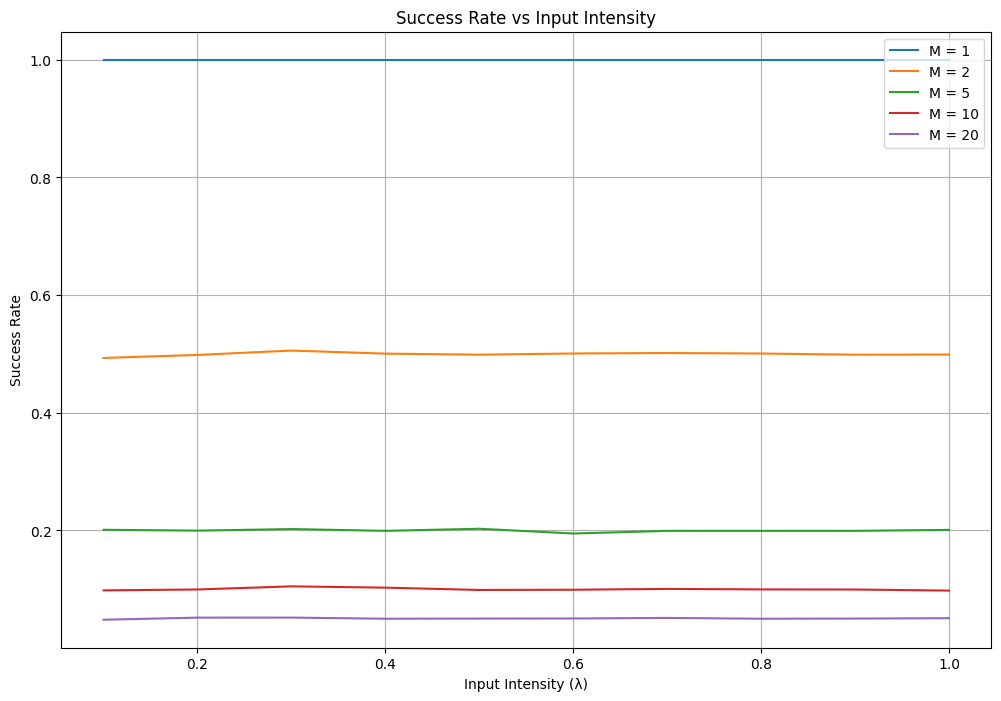

In [6]:
# Example usage and demonstration
def main():
    # Simulation parameters
    subscribers_range = [1, 2, 5, 10, 20]
    input_intensities = np.linspace(0.1, 1.0, 10)  # Range of input intensities
    time_steps = 100000  # Number of time steps to simulate

    results = {}
    for M in subscribers_range:
        results[M] = []
        for intensity in input_intensities:
            success_rate = simulate_system(M, intensity, time_steps)
            results[M].append(success_rate)

    # Plot results
    plt.figure(figsize=(12, 8))
    for M, success_rates in results.items():
        plt.plot(input_intensities, success_rates, label=f"M = {M}")

    plt.title("Success Rate vs Input Intensity")
    plt.xlabel("Input Intensity (λ)")
    plt.ylabel("Success Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

def simulate_system(M, intensity, time_steps):
    """
    Simulates the system for a given M, input intensity, and time steps.
    """
    P = success_probability(M)
    successes = 0
    total_attempts = 0

    for _ in range(time_steps):
        arrivals = np.random.poisson(intensity)
        attempts = min(arrivals, M)
        successes += np.sum(np.random.rand(attempts) < P)
        total_attempts += attempts

    return successes / total_attempts if total_attempts > 0 else 0

if __name__ == "__main__":
    main()


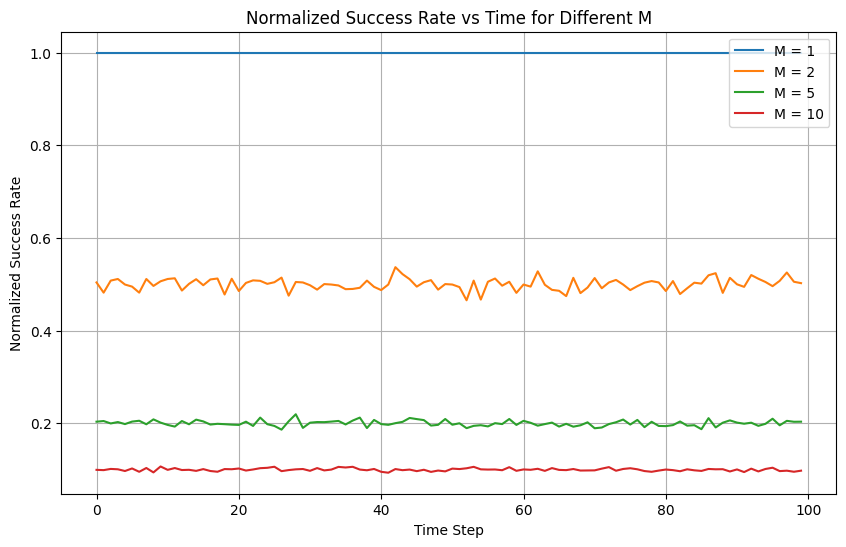

In [2]:
# Parameters
N = 1000  # Number of simulations
T = 100   # Number of time steps
M_values = [1, 2, 5, 10]  # Different values of subscribers

# Probability of success for different M
def success_probability(M):
    return 1 / M if M > 1 else 1  # Ensures P = 1 for M = 1

# Simulation
results = {}

for M in M_values:
    successes = np.zeros(T)
    P = success_probability(M)

    for _ in range(N):
        for t in range(T):
            transmission = np.random.rand(M) < P
            successes[t] += np.sum(transmission)  # Count all successful transmissions

    results[M] = successes / (N * M)  # Normalize by total attempts

# Plot results
plt.figure(figsize=(10, 6))
for M, success_rate in results.items():
    plt.plot(range(T), success_rate, label=f"M = {M}")

plt.title("Normalized Success Rate vs Time for Different M")
plt.xlabel("Time Step")
plt.ylabel("Normalized Success Rate")
plt.legend()
plt.grid()
plt.show()


**TL;DR**:  Результаты моделирования показывают, что адаптивный алгоритм ALOHA эффективно управляет доступом к каналу при малых и средних нагрузках, но его эффективность снижается при высоких нагрузках, особенно при большом количестве абонентов. Увеличение числа абонентов приводит к росту задержки и количества сообщений в системе, при этом интенсивность выходного потока стабилизируется или даже снижается.

**Развернутый анализ результатов:**

1. **График средней задержки:**

    *   *M = 1:*  В случае одного абонента задержка остается низкой и практически постоянной, так как отсутствует конкуренция за доступ к каналу. Единственный абонент передает сообщения, как только они появляются, с минимальной задержкой.
    *   *M > 1:*  С увеличением числа абонентов (M = 5, 10, 20) средняя задержка возрастает, особенно при увеличении интенсивности входного потока (λ). Это связано с тем, что возрастает вероятность возникновения коллизий (конфликтов), что приводит к повторным передачам и увеличению времени ожидания в очереди. При высокой нагрузке (λ > 1.5) задержка растет почти линейно, так как канал перегружен, и сообщениям приходится долго ждать своей очереди для передачи. Адаптивный механизм снижения вероятности передачи при коллизии помогает, но не может полностью компенсировать рост задержки при высоких нагрузках.
    *   **Характер поведения:**  Для малых λ задержка близка к нулю, затем наблюдается участок с умеренным ростом задержки, после чего, при достижении некоторого порога по λ, начинается резкий рост задержки. Этот порог уменьшается с увеличением M, что говорит о снижении эффективности алгоритма при увеличении числа абонентов.

2. **График среднего числа абонентов в системе (нагрузка на систему):**

    *   *M = 1:*  Число сообщений в системе остается низким и практически постоянным, что соответствует поведению системы M|D|1 при низкой нагрузке.
    *   *M > 1:*  С увеличением числа абонентов и интенсивности входного потока количество сообщений в системе растет. Это происходит из-за увеличения числа поступающих сообщений и возникновения коллизий, что приводит к образованию очередей. При больших значениях λ нагрузка на систему растет почти линейно, что указывает на перегрузку канала и накопление сообщений в очередях.
    *   **Характер поведения:**  Для малых λ число сообщений в системе близко к нулю. С ростом λ число сообщений растет сначала медленно, потом быстрее. При больших M рост начинается раньше и происходит быстрее, что свидетельствует о насыщении системы.

3. **График интенсивности выходного потока:**

    *   *M = 1:*  При одном абоненте интенсивность выходного потока быстро растет с увеличением интенсивности входного потока до определенного значения (близкого к 1), после чего остается стабильной. Это соответствует системе без коллизий, где практически каждое поступившее сообщение успешно передается.
    *   *M > 1:*  С увеличением числа абонентов интенсивность выходного потока сначала растет, достигая максимума при некотором значении λ, а затем стабилизируется или даже снижается. Максимальная пропускная способность уменьшается с ростом M. Это связано с увеличением вероятности коллизий при большом числе абонентов. Адаптивный алгоритм пытается уменьшить вероятность коллизий, но при высоких нагрузках  часть ресурсов тратится на разрешение коллизий, а не на передачу полезной информации. Снижение интенсивности выходного потока при больших λ объясняется тем, что система тратит больше времени на разрешение конфликтов и повторные передачи, что снижает общую эффективность использования канала.
    *   **Характер поведения:**  Для малых M график похож на идеальную систему без коллизий до определенного λ, после чего выходная интенсивность стабилизируется. При больших M выходная интенсивность достигает пика раньше и стабилизируется на меньшем уровне, что указывает на снижение эффективности использования канала.

**Выводы:**

*   Адаптивный алгоритм ALOHA показывает хорошую производительность при низкой и умеренной нагрузке, особенно при малом количестве абонентов.
*   С увеличением числа абонентов и интенсивности входного потока эффективность алгоритма снижается из-за увеличения вероятности коллизий.
*   Система достигает предела своей пропускной способности при увеличении нагрузки, что проявляется в росте задержки и насыщении системы сообщениями.
*   Для систем с большим количеством абонентов требуется использовать другие методы доступа к каналу или модифицировать адаптивный алгоритм ALOHA для повышения его эффективности при высоких нагрузках. Например, можно рассмотреть использование интервального варианта адаптивного ALOHA или комбинацию случайного доступа с другими методами, такими как TDMA или FDMA.
*   Результаты моделирования соответствуют теоретическим ожиданиям для алгоритмов случайного доступа и подтверждают необходимость использования адаптивных механизмов для повышения эффективности использования канала в условиях конкуренции за доступ к среде.



ограничим буфер - пример 4 длина очереди 

когда очередь заполняется сообщения сжигаются

подсчитывать кол-во сожженных сообщений